In [1]:
import jax.numpy as jnp
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from tqdm import tqdm_notebook
import pandas as pd
from qmp.qmp_reg_functions import fit_beta, fit_beta_perm,compute_Qx_B,rearrange_Q_x
from qmp.qmp_functions import rearrange_Q


# Setup Colours

In [2]:
palette = sns.color_palette("gist_earth", 6)
color_codes = ['1', '2','3','4','5','6']
c = lambda x: palette[color_codes.index(x)]

# Load

In [3]:
beta_pr_small = np.load('plot_data/beta_pr_n291.npy')
beta_pr_small_exact = np.load('plot_data/beta_pr_exact_n291.npy')

u_plot = np.load('plot_data/u_plot_reg.npy')
du = u_plot[1]- u_plot[0]
n_plot = np.shape(u_plot)[0]

normalize = np.load("plot_data/normalize_reg_n291.npy",allow_pickle=True).item()
hyperparam = np.load("plot_data/hyperparam_reg_opt_n291.npy",allow_pickle=True).item()
data  = np.load("plot_data/data_reg_n291.npy",allow_pickle=True).item()
y = data['y']
x = data['x']
print(hyperparam)
print(normalize)

#Unnormalize
ratio = normalize['sd_y']/normalize['sd_x']

{'a': 3.4081036369812794, 'c': 0.9500000000000001, 'k': 0.5, 'd': 2, 'B': 10000}
{'mean_x': array([1995.43986254]), 'sd_x': array([7.54452934]), 'mean_y': 71.04722690522715, 'sd_y': 24.999765995453366}


In [4]:
# Precompute
#Approximate
beta_mean = np.mean(beta_pr_small,axis = 0)
beta_low = np.quantile(beta_pr_small,axis = 0, q = 0.025)
beta_hi = np.quantile(beta_pr_small,axis= 0, q = 0.975)

#Exact
beta_mean_exact = np.mean(beta_pr_small_exact,axis = 0)
beta_low_exact = np.quantile(beta_pr_small_exact,axis = 0, q = 0.025)
beta_hi_exact = np.quantile(beta_pr_small_exact,axis= 0, q = 0.975)

# Plot

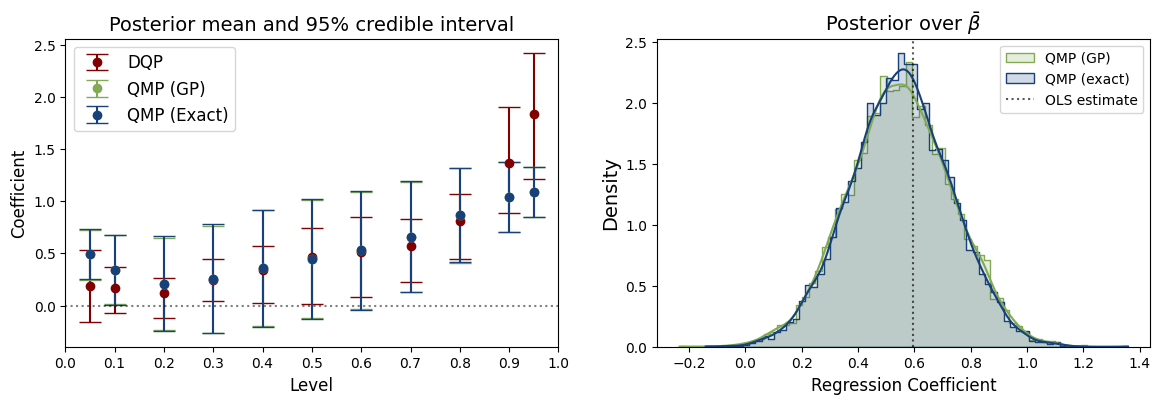

In [5]:
#Rescale for plots
f = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)


u_ind = np.array([9,19,39,59,79,99,119,139,159,179,189])


#Load DQP
beta_dqp = pd.read_csv('plot_data/DQP_beta1.csv').iloc[np.array([0,1,2,4,6,7,8,10,12,13,14])]
beta_dqp_mean = np.array(beta_dqp['Slope'])
beta_dqp_low = np.array(beta_dqp['q025'])
beta_dqp_hi = np.array(beta_dqp['q975'])

plt.errorbar(x = np.array(beta_dqp['Level']), y = beta_dqp_mean,yerr = np.vstack(((beta_dqp_hi - beta_dqp_mean).reshape(1,-1) ,(beta_dqp_mean -beta_dqp_low).reshape(1,-1))),
             capsize = 8,fmt = 'o',color = 'maroon',label = 'DQP')

plt.errorbar(x = np.round(u_plot[u_ind],2), y = ratio*beta_mean_exact[u_ind,1],yerr = ratio*np.vstack((beta_hi_exact[u_ind,1]-beta_mean_exact[u_ind,1] ,beta_mean_exact[u_ind,1] -beta_low_exact[u_ind,1])),
             capsize = 8,fmt = 'o',label = 'QMP (GP)',color = c('4'))
plt.errorbar(x = np.round(u_plot[u_ind],2), y = ratio*beta_mean[u_ind,1],yerr = ratio*np.vstack((beta_hi[u_ind,1]-beta_mean[u_ind,1] ,beta_mean[u_ind,1] -beta_low[u_ind,1])),
             capsize = 8,fmt = 'o',label = 'QMP (Exact)',color = c('1'))
plt.axhline(0,color = 'k',ls = ':',alpha = 0.5)




plt.legend(fontsize = 12)
plt.xlabel('Level',fontsize = 12)
plt.ylabel('Coefficient',fontsize = 12)
plt.title('Posterior mean and 95% credible interval',fontsize = 14)
plt.xticks(np.arange(0,1.1,0.1))

plt.subplot(1,2,2)
beta_linreg = np.sum(beta_pr_small[:,:,1],axis = 1)*du
sns.histplot(beta_linreg*ratio,label = r'QMP (GP)',alpha  = 0.2, stat = 'density', kde = True,element="step",color = c('4'))
beta_linreg_exact = np.sum(beta_pr_small_exact[:,:,1],axis = 1)*du
sns.histplot(beta_linreg_exact*ratio,label = r'QMP (exact)',alpha  = 0.2, stat = 'density', kde = True,element="step",color = c('1'))

plt.axvline(1.790786e-01*ratio,label = 'OLS estimate',color = 'k',alpha = 0.65, ls = ':')
plt.legend()
plt.title(r'Posterior over $\bar{\beta}$ ',fontsize = 14)
plt.xlabel('Regression Coefficient',fontsize = 12)
plt.ylabel('Density',fontsize = 14)
f.savefig('reg_small_beta.pdf', bbox_inches='tight')


# Plot conditional quantiles

In [6]:
#QMP
n_plot_x = 50
x_plot = np.linspace(np.min(x),np.max(x),n_plot_x)
x_plot = np.hstack((np.ones(n_plot_x).reshape(-1,1),x_plot.reshape(-1,1))) #add intercept

Q_x_pr = compute_Qx_B(beta_pr_small,x_plot)
#Unnormalize
Q_x_pr = Q_x_pr*normalize['sd_y'] + normalize['mean_y']
mean = np.mean(Q_x_pr,axis = 0)
low = np.quantile(Q_x_pr,axis = 0, q = 0.025)
hi = np.quantile(Q_x_pr,axis= 0, q = 0.975)

#Baseline
tau_plot = pd.read_csv('plot_data/tau_plot.csv')['x']
beta_qr = np.zeros((np.shape(tau_plot)[0],2))
beta_qr[:,0] =pd.read_csv('plot_data/intercept_small.csv')['x']
beta_qr[:,1] =pd.read_csv('plot_data/beta_small.csv')['x']

Q_x_qr = np.dot(beta_qr, x_plot.transpose())
Q_x_qr_rearr = rearrange_Q_x(Q_x_qr)
Q_x_qr_rearr = Q_x_qr_rearr*normalize['sd_y'] + normalize['mean_y']

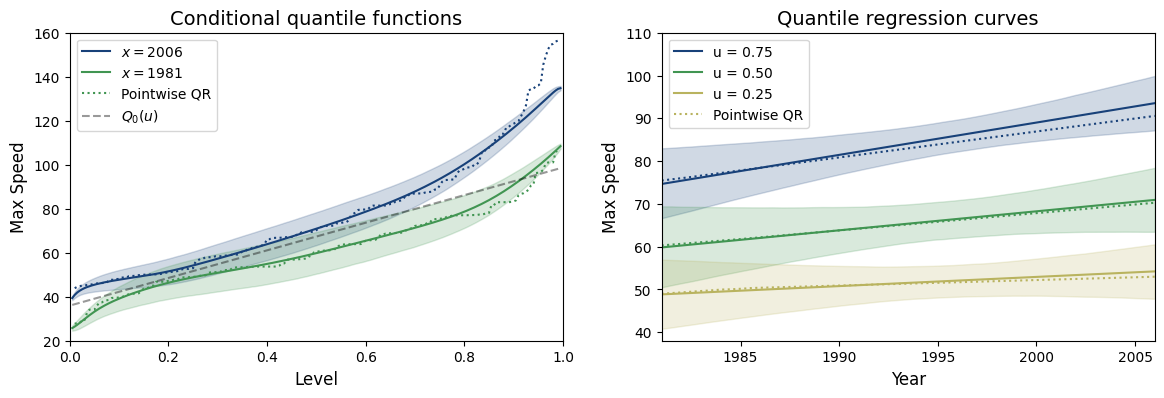

In [7]:
f = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)

j = 49
plt.plot(u_plot,mean[j,:],label = r'$x=${}'.format(2006),color = c('1'))
plt.fill_between(u_plot,low[j,:], hi[j,:], alpha = 0.2,color = c('1'))
plt.plot(tau_plot[1:-1],Q_x_qr_rearr[j,1:-1],ls = ':',color = c('1'),alpha = 1.)


j = 0
plt.plot(u_plot,mean[j,:],label = r'$x=${}'.format(1981),color = c('3'))
plt.fill_between(u_plot,low[j,:], hi[j,:], alpha = 0.2,color = c('3'))
plt.plot(tau_plot[1:-1],Q_x_qr_rearr[j,1:-1],ls = ':',color = c('3'),alpha = 1.,label ='Pointwise QR')

# #Initial Q0
q25 = jnp.quantile(y,0.25)
q75 = jnp.quantile(y,0.75)
b = 2*(q75 - q25) #slope = 2*iqr
d = q25 - 0.25*b
Q_init = (b*u_plot + d)
plt.plot(u_plot,Q_init*normalize['sd_y'] + normalize['mean_y'],label = r'$Q_0(u)$',color = 'k', ls = '--',alpha = 0.4)

plt.ylim(20,160)
plt.xlim(0,1)
plt.xlabel(r'Level', fontsize = 12)
plt.ylabel(r'Max Speed', fontsize = 12)
plt.legend(fontsize = 10)
plt.title('Conditional quantile functions',fontsize = 14)

plt.subplot(1,2,2)

i = 149
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),mean[:,i],label = 'u = {}'.format(0.75),color = c('1'))
plt.fill_between((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),low[:,i], hi[:,i], alpha = 0.2, color = c('1'))
plt.ylim(38,110)
plt.xlim(1981,2006)
plt.ylabel(r'Max Speed',fontsize = 12)
plt.xlabel(r'Year',fontsize = 12)
plt.title('Quantile regression curves',fontsize = 14)
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),Q_x_qr_rearr[:,i],ls = ':',color = c('1'),alpha = 1.)


i = 99
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),mean[:,i],label = 'u = 0.50',color = c('3'))
plt.fill_between((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),low[:,i], hi[:,i], alpha = 0.2,color = c('3'))
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),Q_x_qr_rearr[:,i],ls = ':',color = c('3'),alpha = 1.)


i = 49
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),mean[:,i],label = 'u = {}'.format(0.25),color = c('5'))
plt.fill_between((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),low[:,i], hi[:,i], alpha = 0.2,color = c('5'))
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),Q_x_qr_rearr[:,i],ls = ':',color =c('5'),alpha = 1.,label = 'Pointwise QR')

plt.legend(fontsize = 10)


f.savefig('reg_small.pdf', bbox_inches='tight')

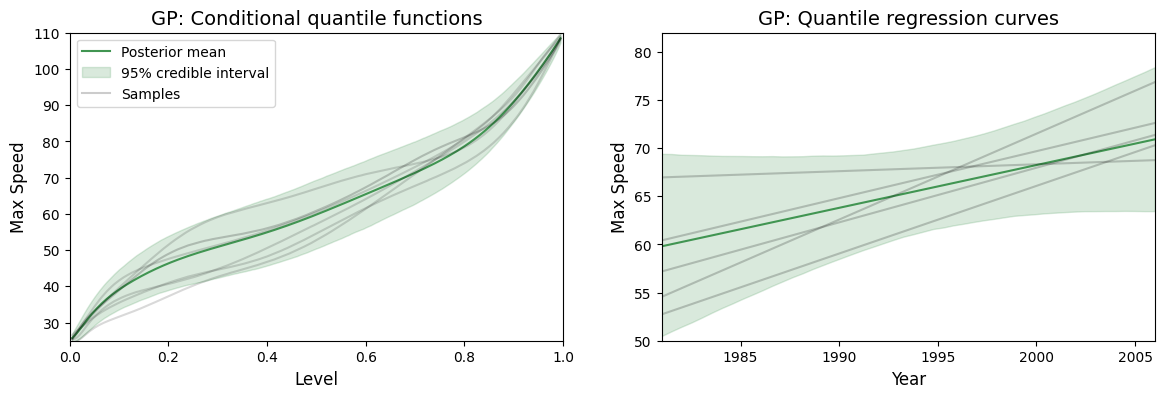

In [8]:
f = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)

j = 0
plt.plot(u_plot,mean[j,:],label = r'Posterior mean',color = c('3'))
plt.fill_between(u_plot,low[j,:], hi[j,:], alpha = 0.2,color = c('3'),label = '95% credible interval')

# #Initial Q0
q25 = jnp.quantile(y,0.25)
q75 = jnp.quantile(y,0.75)
b = 2*(q75 - q25) #slope = 2*iqr
d = q25 - 0.25*b
Q_init = (b*u_plot + d)


plt.plot(u_plot,Q_x_pr[-1,j],color = 'k',alpha = 0.2,label = 'Samples')
for b in range(5):
    plt.plot(u_plot,Q_x_pr[b,j],color = 'k',alpha = 0.15)


plt.ylim(25,110)
plt.xlim(0,1)
plt.xlabel(r'Level', fontsize = 12)
plt.ylabel(r'Max Speed', fontsize = 12)
plt.legend(fontsize = 10)
plt.title('GP: Conditional quantile functions',fontsize = 14)

plt.subplot(1,2,2)


i = 99
plt.ylim(50,82)
plt.xlim(1981,2006)
plt.ylabel(r'Max Speed',fontsize = 12)
plt.xlabel(r'Year',fontsize = 12)
plt.title('GP: Quantile regression curves',fontsize = 14)
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),mean[:,i],color = c('3'))
plt.fill_between((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),low[:,i], hi[:,i], alpha = 0.2,color = c('3'))

for b in range(5):
    plt.plot(x_plot[:,1]*normalize['sd_x'] +normalize['mean_x'],Q_x_pr[b,:,i],color = 'k',alpha = 0.2)

f.savefig('reg_small_samples.pdf', bbox_inches='tight')

## Exact

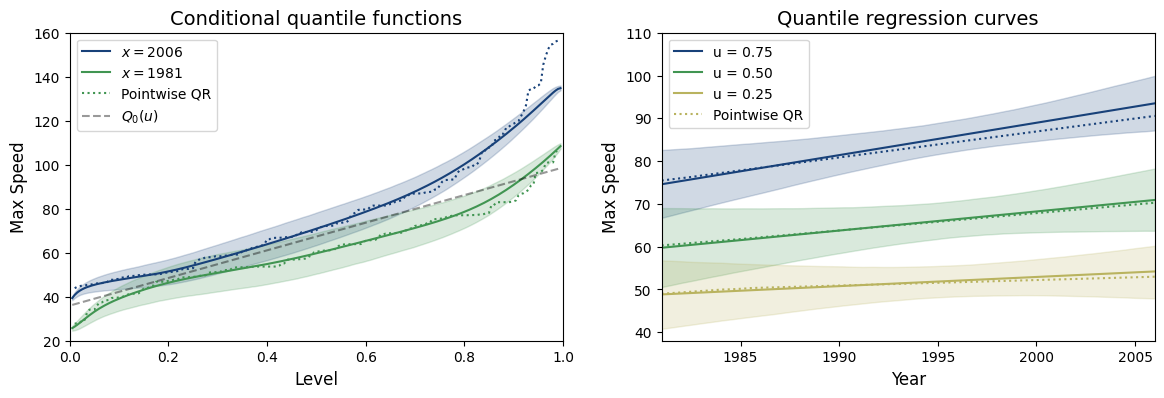

In [9]:
Q_x_pr_exact = compute_Qx_B(beta_pr_small_exact,x_plot)
#Unnormalize
Q_x_pr_exact = Q_x_pr_exact*normalize['sd_y'] + normalize['mean_y']
mean_exact = np.mean(Q_x_pr_exact,axis = 0)
low_exact = np.quantile(Q_x_pr_exact,axis = 0, q = 0.025)
hi_exact = np.quantile(Q_x_pr_exact,axis= 0, q = 0.975)

f = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)

j = 49
plt.plot(u_plot,mean_exact[j,:],label = r'$x=${}'.format(2006),color = c('1'))
plt.fill_between(u_plot,low[j,:], hi_exact[j,:], alpha = 0.2,color = c('1'))
plt.plot(tau_plot[1:-1],Q_x_qr_rearr[j,1:-1],ls = ':',color = c('1'),alpha = 1.)


j = 0
plt.plot(u_plot,mean_exact[j,:],label = r'$x=${}'.format(1981),color = c('3'))
plt.fill_between(u_plot,low[j,:], hi_exact[j,:], alpha = 0.2,color = c('3'))
plt.plot(tau_plot[1:-1],Q_x_qr_rearr[j,1:-1],ls = ':',color = c('3'),alpha = 1.,label ='Pointwise QR')

# #Initial Q0
q25 = jnp.quantile(y,0.25)
q75 = jnp.quantile(y,0.75)
b = 2*(q75 - q25) #slope = 2*iqr
d = q25 - 0.25*b
Q_init = (b*u_plot + d)
plt.plot(u_plot,Q_init*normalize['sd_y'] + normalize['mean_y'],label = r'$Q_0(u)$',color = 'k', ls = '--',alpha = 0.4)

plt.ylim(20,160)
plt.xlim(0,1)
plt.xlabel(r'Level', fontsize = 12)
plt.ylabel(r'Max Speed', fontsize = 12)
plt.legend(fontsize = 10)
plt.title('Conditional quantile functions',fontsize = 14)

plt.subplot(1,2,2)

i = 149
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),mean_exact[:,i],label = 'u = {}'.format(0.75),color = c('1'))
plt.fill_between((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),low_exact[:,i], hi_exact[:,i], alpha = 0.2, color = c('1'))
plt.ylim(38,110)
plt.xlim(1981,2006)
plt.ylabel(r'Max Speed',fontsize = 12)
plt.xlabel(r'Year',fontsize = 12)
plt.title('Quantile regression curves',fontsize = 14)
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),Q_x_qr_rearr[:,i],ls = ':',color = c('1'),alpha = 1.)


i = 99
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),mean_exact[:,i],label = 'u = 0.50',color = c('3'))
plt.fill_between((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),low_exact[:,i], hi_exact[:,i], alpha = 0.2,color = c('3'))
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),Q_x_qr_rearr[:,i],ls = ':',color = c('3'),alpha = 1.)

i = 49
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),mean_exact[:,i],label = 'u = {}'.format(0.25),color = c('5'))
plt.fill_between((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),low_exact[:,i], hi_exact[:,i], alpha = 0.2,color = c('5'))
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),Q_x_qr_rearr[:,i],ls = ':',color =c('5'),alpha = 1.,label = 'Pointwise QR')

plt.legend(fontsize = 10)


f.savefig('reg_small_exact.pdf', bbox_inches='tight')

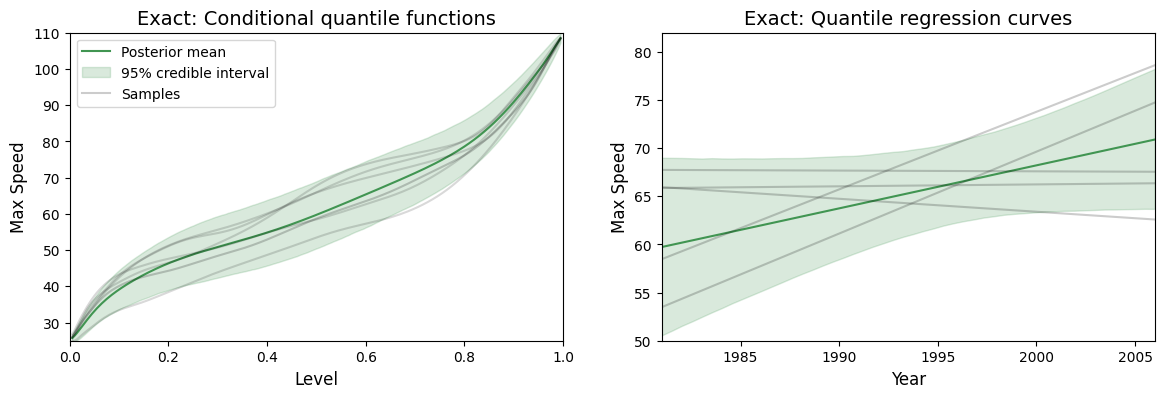

In [10]:
f = plt.figure(figsize = (14,4))
plt.subplot(1,2,1)

j = 0
plt.plot(u_plot,mean_exact[j,:],label = r'Posterior mean',color = c('3'))
plt.fill_between(u_plot,low[j,:], hi_exact[j,:], alpha = 0.2,color = c('3'),label = '95% credible interval')
#plt.plot(tau_plot[1:-1],Q_x_qr_rearr[j,1:-1],ls = ':',color = c('3'),alpha = 1.,label ='Pointwise QR')

# #Initial Q0
q25 = jnp.quantile(y,0.25)
q75 = jnp.quantile(y,0.75)
b = 2*(q75 - q25) #slope = 2*iqr
d = q25 - 0.25*b
Q_init = (b*u_plot + d)


plt.plot(u_plot,Q_x_pr_exact[-1,j],color = 'k',alpha = 0.2,label = 'Samples')
for b in range(5):
    plt.plot(u_plot,Q_x_pr_exact[b,j],color = 'k',alpha = 0.15)


plt.ylim(25,110)
plt.xlim(0,1)
plt.xlabel(r'Level', fontsize = 12)
plt.ylabel(r'Max Speed', fontsize = 12)
plt.legend(fontsize = 10)
plt.title('Exact: Conditional quantile functions',fontsize = 14)

plt.subplot(1,2,2)


i = 99
plt.ylim(50,82)
plt.xlim(1981,2006)
plt.ylabel(r'Max Speed',fontsize = 12)
plt.xlabel(r'Year',fontsize = 12)
plt.title('Exact: Quantile regression curves',fontsize = 14)
plt.plot((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),mean_exact[:,i],color = c('3'))
plt.fill_between((x_plot[:,1]*normalize['sd_x'] +normalize['mean_x']),low_exact[:,i], hi_exact[:,i], alpha = 0.2,color = c('3'))

for b in range(5):
    plt.plot(x_plot[:,1]*normalize['sd_x'] +normalize['mean_x'],Q_x_pr_exact[b,:,i],color = 'k',alpha = 0.2)


f.savefig('reg_small_exact_samples.pdf', bbox_inches='tight')

# Big datatset

## Load

In [11]:
beta_pr_big = np.load('plot_data/beta_pr_n2097.npy')
beta_pr_big_exact = np.load('plot_data/beta_pr_exact_n2097.npy')

u_plot = np.load('plot_data/u_plot_reg.npy')
du = u_plot[1]- u_plot[0]
n_plot = np.shape(u_plot)[0]

normalize = np.load("plot_data/normalize_reg_n2097.npy",allow_pickle=True).item()
hyperparam = np.load("plot_data/hyperparam_reg_opt_n2097.npy",allow_pickle=True).item()
data  = np.load("plot_data/data_reg_n2097.npy",allow_pickle=True).item()
y = data['y']
x = data['x'] #['Year','Age','Lat','PC1','PC2','PC3','PC4','PC5','PC6']
n = np.shape(x)[0]
d = np.shape(x)[1]
print(hyperparam)
print(normalize)

#Unnormalize
ratio = normalize['sd_y']/normalize['sd_x']

#QR Baseline
tau_plot = pd.read_csv('plot_data/tau_plot.csv')['x']
beta_qr = np.array(pd.read_csv('plot_data/beta_big.csv').iloc[:,1:])


{'a': 2.3517731927838237, 'c': 0.9500000000000001, 'k': 0.5, 'd': 4, 'B': 10000}
{'mean_x': Year    1993.662375
Age       18.979495
Lat        9.941059
dtype: float64, 'sd_x': Year     7.426543
Age     15.311518
Lat     17.252917
dtype: float64, 'mean_y': 77.20764618058746, 'sd_y': 24.133799563243894}


In [12]:
#Setup plot
j = 2 #corresponds to Cyclone age
n_plot_x = 50
age_plot = np.linspace(np.min(x[:,j]),np.max(x[:,j]),n_plot_x).reshape(-1,1)
x_plot = np.zeros((n_plot_x, d)) #add intercept
x_plot[:,1] = np.ones(n_plot_x)
x_plot[:,j] = age_plot[:,0]

#QMP
Q_x_QMP = compute_Qx_B(beta_pr_big,x_plot)
Q_x_QMP_rearr = rearrange_Q_x(Q_x_QMP)*normalize['sd_y'] + normalize['mean_y']
mean_QMP = np.mean(Q_x_QMP_rearr,axis = 1)
low_QMP = np.quantile(Q_x_QMP_rearr,axis = 1,q= 0.025)
hi_QMP = np.quantile(Q_x_QMP_rearr,axis = 1, q=0.975)

#QR
Q_x_QR = np.dot(beta_qr, x_plot.transpose())
Q_x_QR_rearr = rearrange_Q_x(Q_x_QR)*normalize['sd_y'] + normalize['mean_y']


# Plot

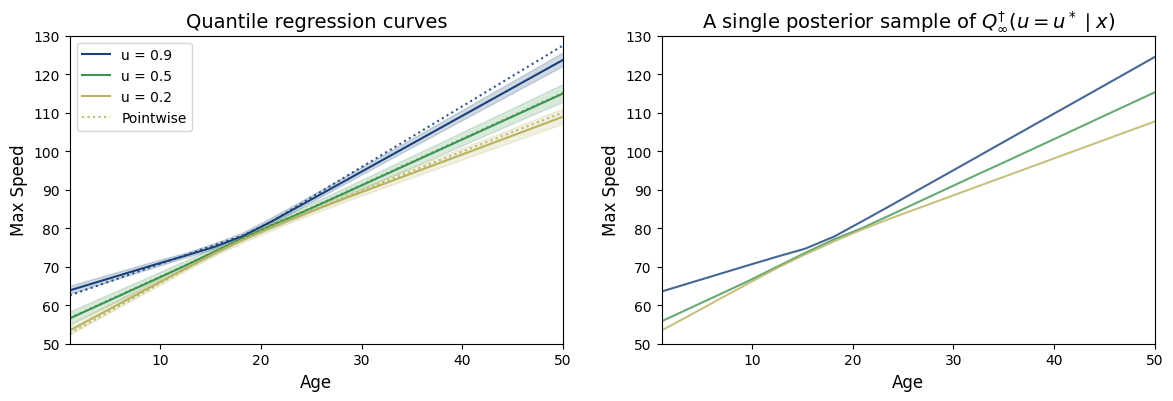

In [37]:
f = plt.figure(figsize = (14,4))
palette = sns.color_palette("gist_earth", 6)
color_codes = ['1', '2','3','4','5','6']
c = lambda x: palette[color_codes.index(x)]


plt.subplot(1,2,1)
x_plot_scaled = x_plot[:,j]*normalize['sd_x']['Age'] +normalize['mean_x']['Age']

i = 179
plt.plot(x_plot_scaled,mean_QMP[:,i],label = 'u = {}'.format(0.9),color = c('1'))
plt.fill_between(x_plot_scaled,low_QMP[:,i], hi_QMP[:,i], alpha = 0.2,color = c('1'))
plt.ylim(50,130)
#plt.xlim(1981,2006)
plt.xlim(1,50)
plt.ylabel(r'Max Speed',fontsize = 12)
plt.xlabel(r'Age',fontsize = 12)
plt.title('Quantile regression curves',fontsize = 14)
plt.plot(x_plot_scaled,Q_x_QR_rearr[:,i],ls = ':',color = c('1'),alpha = 0.9)


i = 99
plt.plot(x_plot_scaled,mean_QMP[:,i],label = 'u = {}'.format(0.5),color = c('3'))
plt.fill_between(x_plot_scaled,low_QMP[:,i], hi_QMP[:,i], alpha = 0.2,color = c('3'))
plt.plot(x_plot_scaled,Q_x_QR_rearr[:,i],ls = ':',color = c('3'),alpha = 0.9)
# for b in range(5):
#     plt.plot(x_plot[:,1],Q_x_pr[b,:,i],color = 'maroon',alpha = 0.15)

i = 39
plt.plot(x_plot_scaled,mean_QMP[:,i],label = 'u = {}'.format(0.2),color = c('5'))
plt.fill_between(x_plot_scaled,low_QMP[:,i], hi_QMP[:,i], alpha = 0.2,color = c('5'))
plt.plot(x_plot_scaled,Q_x_QR_rearr[:,i],ls = ':',color = c('5'),alpha = 0.9,label = 'Pointwise')
plt.legend()

plt.subplot(1,2,2)
palette2 = sns.color_palette(palette='muted')
color_codes2 = ['1', '2','3','4','5','6']
c2 = lambda x: palette2[color_codes2.index(x)]


i = 179
plt.ylim(50,130)
plt.xlim(1,50)
plt.ylabel(r'Max Speed',fontsize = 12)
plt.xlabel(r'Age',fontsize = 12)
plt.title('A single posterior sample of $Q^{\dagger}_\infty(u=u^*\mid x)$',fontsize = 14)
b = 10
plt.plot(x_plot_scaled,Q_x_QMP_rearr[:,b,179],color = c('1'),alpha = 0.8, label ='u = 0.9')
plt.plot(x_plot_scaled,Q_x_QMP_rearr[:,b,99],color = c('3'),alpha = 0.8, label ='u = 0.5')
plt.plot(x_plot_scaled,Q_x_QMP_rearr[:,b,39],color = c('5'),alpha = 0.8,  label ='u = 0.2')

f.savefig('reg_big.pdf', bbox_inches='tight')